<a href="https://colab.research.google.com/github/savibatuan/PHYS486-S22/blob/main/FinalProject/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import for all simulations below**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.linalg as la
import matplotlib.animation as animation

**Generic Random Walk without Defect**

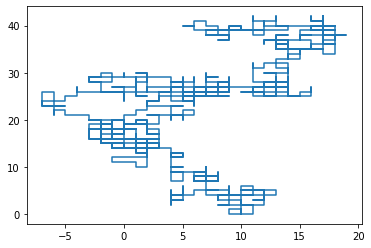

In [120]:
#the number of steps the simulation is going to move
step = 1000
#the allowed grid size on which the simulation will be performed(i.e grid= 10 will produce 10x10 matrix)
grid = 10

#Create the arrays to store positions in x and y direction
#Starting movement from the midpoint
if grid % 2 == 0: #checks if given grid is divisible by 2 to find midpoint
  midpoint = grid/2
else:
    midpoint = (grid-1)/2 #if not divisable by 2, then subtract one and then find midpoint
x = np.full((step) , midpoint)
y = np.full((step), midpoint)

#Creating the directions the simulation can move in
direction=["Up", "Down", "Left", "Right"]

#Creating a matrix from the given grid size, within which the simulation is allowed to move
def matrix(grid):
  rows = grid
  cols = grid
  return rows, cols
  
rows, cols = matrix(grid)

for i in range(1,step):
  move = random.choice(direction)
  if move == "Up":
    if y[i] == rows : #if the simulation position is at the top of the allowed matrix the move will be disregarded
      x[i] = x[i-1]
      y[i] = y[i-1]
    else:
      x[i] = x[i-1]
      y[i] = y[i-1] + 1 #otherwise it will move one position up

  elif move == "Down":
    if y[i] == 0:
      x[i] = x[i-1]
      y[i] = y[i-1]
    else:
      x[i] = x[i-1]
      y[i] = y[i-1] -1


  elif move == "Left":
    if x[i] == 0:
      x[i] = x[i-1]
      y[i] = y[i-1]
    else:    
      x[i] = x[i-1] -1
      y[i] = y[i-1]


  elif move == "Right":
    if x[i] == cols:
      x[i] = x[i-1]
      y[i] = y[i-1]
    else:
      x[i] = x[i-1] +1
      y[i] = y[i-1]

plt.plot(x,y)
plt.show()


**Max Entopy Random Walk with Defects**



In [131]:
#Setting up the same initial conditions as the generic random walk

#Since this is not running as a simulation, the step size is not needed for the main portion
#The post-work attempt at a simulation does require a step size, but is not used in the main
step = 1000 
grid = 10

if grid % 2 == 0: 
  midpoint = grid/2
else:
    midpoint = (grid-1)/2
x = np.full((step) , midpoint)
y = np.full((step), midpoint)

direction=["Up", "Down", "Left", "Right"]

def matrix(grid):
  rows = grid
  cols = grid
  return rows, cols

rows, cols = matrix(grid)
full_grid = int(rows*cols)

In [132]:
#Setting the intial conditions for the density 

#The density of defects within a given grid
density = .1 

#Determines the numbers of defects in the given grid
num_defects = int(density * rows * cols)

print("Total Defects: ", num_defects)

Total Defects:  10


In [133]:
#First creating an intial matrix for the simulation to run on
#Takes in the size of the input grid and returns all the possible positions on the grid

def create_matrix(grid):
  #Creates a matrix filled with zeros
  vector = np.zeros(grid) 
  #Sets vector in index 1 and -1 to 1
  vector[1] = 1 
  vector [-1] = 1
  #Creates a circulant matrix the size of the given grid. Looks like ones on the longest off diagonals and ones in the upper right corener and lower left corner
  offDiagonal = la.circulant(vector)
  #Creates array with ones on the diagonal and zeros everywhere else
  diagonal = np.eye(grid)
  #Finds the Kronecker product of the diagonal and offdiagonals
  #The primary reason for this move is to remove the ones in the corners
  initial_matrix = np.kron(offDiagonal, diagonal) + np.kron (diagonal, offDiagonal) 
  print(initial_matrix)
  #Returns an intial matrix populated 
  return initial_matrix 

In [134]:
#Randomly determine the position of the defects in the established inital matrix

def add_defects(initial_matrix, num_defects):
  for i in range (num_defects):
    #For every defect, a random position is assigned within the inital matrix
    defect_position = np.random.randint(0, rows*cols)
    #Sets the x position of the defect in the matrix
    initial_matrix[defect_position, :] = 0
    #Sets the y position of the defect in the matrix
    initial_matrix[:, defect_position] = 0
  return initial_matrix

In [135]:
#Adds the defects to the graph, from the position they are randomly assigned from add_defects
def add_to_graph(intial_matrix):
  #Finds where in the initial matrix the value is equal to zero
  zero_row = np.where(~intial_matrix.any(axis=0))[0]
  #Finds where in the initial matrix the value is equal to one
  zero_col = np.where(~intial_matrix.any(axis=1))[0]

  #Creates a matrix filled with ones
  lat = np.ones([grid,grid])
  #print(zero_row, zero_col)

  #For the zero row, update the rows and cols to where there are ones and zeros in the correct places
  for i in range(zero_row.shape[0]):
      rows = int(zero_row[i] / grid)
      cols = int(zero_col[i] % grid)
      lat[rows,cols]=0
  return lat

In [136]:
matrix = create_matrix(grid)
matrix = add_defects(matrix, num_defects)
Lattice = add_to_graph(matrix)

#Diagonalize the matrix to find eigenvalues
diag_adj = np.diag(matrix)

#Find the eigenvalues and eigenvectors
eig_values, eig_vectors = la.eig(matrix)

#Imaginary parts are set to zero, if they are close to zero
eig_values = np.real_if_close(eig_values, tol=1)
eig_vectors = np.real_if_close(eig_vectors, tol=1)

#Find the maximum eigenvalue, this will determine where the "most traveled" part of the simulation would be
max_Evalue = np.amax(eig_values)

#Find the placement of the largest eigenvalue
max_index = np.where(eig_values == np.amax(eig_values))

#Transposes the eigenvectors with index 0
max_Evector = eig_vectors.T[0]

#Creating empty arrays to fill in the next step
density= np.zeros((grid*grid))
eig_density= np.zeros((grid*grid))

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


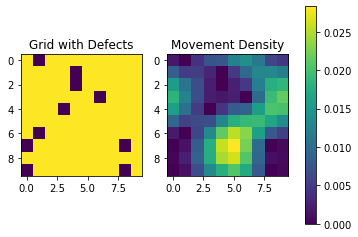

In [137]:
from numpy.ma.core import right_shift
for i in range (grid*grid):
    #The eigen vectors are transposed at each place in the grid
    eig_density[i] = eig_vectors.T[0][i] * eig_vectors.T[0][i]
    #The maximum eigenvector is taken at each position
    density[i]= max_Evector[i] * max_Evector[i]

#The maximum eigenvector are reshaped to fit within the given grid
density=np.reshape(density,[grid,grid])
#The eigenvectors are also reshaped to fit the grid
eig_density=np.reshape(eig_density,[grid,grid])

#print("Movement Density: ", density)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(Lattice.T)
axs[0].set_title("Grid with Defects")
graph = axs[1].imshow(density.T)
axs[1].set_title("Movement Density")
fig.colorbar(graph, ax=axs)

#fig.tight_layout()


Below the movement probability shown through steps. The purpose is to show how the true simulation would work and make decisions through probability instead of using eigenvalues. It's still has a bug, but is not a part of the final solution. It does give some values that can be analyzed. Copied from Github user, didn't have time to work through it. 

In [138]:
def NN_prob(x0,y0):
    i = int(x0 + (grid*(y0)))
    #print("x,y,i:", x0, y0,i)

    ind = np.asarray(np.nonzero(matrix[i]))[0]
    #print("Total neighbours:", len(ind))
    prob = [0,0,0,0]
    #print("Non-Zero Indices for :", x0, y0)
    for j in range(len(ind)):
        nbr = ind[j]
        val = matrix[i, nbr]
        x1 = nbr % grid
        y1 = int(nbr / grid)
        dx = x1 - x0
        dy = y1 - y0
        move = ""
        if dx == -1:
            move = "Left"
            prob[2] = abs((val* max_Evector[nbr])/( max_Evalue * max_Evector[i]))
        elif dx == 1:
            move = "Right"
            prob[3] = abs((val* max_Evector[nbr])/( max_Evalue * max_Evector[i]))
        elif dy == 1:
            move = "Down"
            prob[1] = abs((val* max_Evector[nbr])/( max_Evalue * max_Evector[i]))
        elif dy == -1:
            move = "Up"
            prob[0] = abs((val* max_Evector[nbr])/( max_Evalue * max_Evector[i]))
        elif dx > 1:
            move = "Left"
            prob[2] = abs((val* max_Evector[nbr])/( max_Evalue * max_Evector[i]))
        elif dx < -1:
            move = "Right"
            prob[3] = abs((val* max_Evector[nbr])/( max_Evalue * max_Evector[i]))
        elif dy > 1:
            move = "Up"
            prob[0] = abs((val* max_Evector[nbr])/( max_Evalue * max_Evector[i]))
        elif dy < -1:
            move = "Down"
            prob[1] = abs((val* max_Evector[nbr])/( max_Evalue * max_Evector[i]))
        else:
            move = "Other"
        #print(x1, y1)
        #print("dx,dy:", dx, dy, move)
    print(prob[0]+prob[1]+prob[2]+prob[3])
    prob[:]= prob[:]/ (prob[0]+prob[1]+prob[2]+prob[3])
    return prob

In [139]:
from numpy.core.numeric import moveaxis
#Using the same code as the intitial random walk
for i in range(1, full_grid):
    move_prob = NN_prob(int(x[i-1]%grid),int(y[i-1]%grid))
    print(move_prob)
    move = np.random.choice(direction, p=move_prob)
    print("MOVED:", move)
    if move == "Up":
      if y[i] == rows : #if the simulation position is at the top of the allowed matrix the move will be disregarded
        x[i] = x[i-1]
        y[i] = y[i-1]
      else:
        x[i] = x[i-1]
        y[i] = y[i-1] + 1 #otherwise it will move one position up

    elif move == "Down":
      if y[i] == 0:
        x[i] = x[i-1]
        y[i] = y[i-1]
      else:
        x[i] = x[i-1]
        y[i] = y[i-1] -1


    elif move == "Left":
      if x[i] == 0:
        x[i] = x[i-1]
        y[i] = y[i-1]
      else:    
        x[i] = x[i-1] -1
        y[i] = y[i-1]


    elif move == "Right":
      if x[i] == cols:
        x[i] = x[i-1]
        y[i] = y[i-1]
      else:
        x[i] = x[i-1] +1
        y[i] = y[i-1]


1.000000000000004
[0.22664505284914874, 0.2743938316064237, 0.18110062633357762, 0.3178604892108498]
MOVED: Right
1.0000000000000036
[0.24364956948195107, 0.25410875874325906, 0.22219888296232743, 0.28004278881246236]
MOVED: Left
1.000000000000004
[0.22664505284914874, 0.2743938316064237, 0.18110062633357762, 0.3178604892108498]
MOVED: Right
1.0000000000000036
[0.24364956948195107, 0.25410875874325906, 0.22219888296232743, 0.28004278881246236]
MOVED: Right
1.0000000000000018
[0.25379525128419966, 0.23688819834993255, 0.2522051931421376, 0.2571113572237302]
MOVED: Up
1.0000000000000038
[0.2981501236974983, 0.17621799432061894, 0.27053922071407716, 0.25509266126780566]
MOVED: Down
1.0000000000000018
[0.25379525128419966, 0.23688819834993255, 0.2522051931421376, 0.2571113572237302]
MOVED: Right
1.0000000000000022
[0.25605557043393895, 0.23502828343532592, 0.2746990502603568, 0.23421709587037837]
MOVED: Right
1.0000000000000013
[0.2479431442309268, 0.243971655314729, 0.30155034318928403, 0

TypeError: ignored

**Random Walk with Defects**

Only one line of code is changed from before in the main simulation

In [110]:
#Setting up the same initial conditions as the generic random walk

#Since this is not running as a simulation, the step size is not needed for the main portion
#The post-work attempt at a simulation does require a step size, but is not used in the main
step = 1000 
grid = 10

if grid % 2 == 0: 
  midpoint = grid/2
else:
    midpoint = (grid-1)/2
x = np.full((step) , midpoint)
y = np.full((step), midpoint)

direction=["Up", "Down", "Left", "Right"]

def matrix(grid):
  rows = grid
  cols = grid
  return rows, cols

rows, cols = matrix(grid)
full_grid = rows*cols

In [111]:
#Setting the intial conditions for the density 

#The density of defects within a given grid
density = .1 

#Determines the numbers of defects in the given grid
num_defects = int(density * rows * cols)

print("Total Defects: ", num_defects)

Total Defects:  10


In [112]:
#First creating an intial matrix for the simulation to run on
#Takes in the size of the input grid and returns all the possible positions on the grid

def create_matrix(grid):
  #Creates a matrix filled with zeros
  vector = np.zeros(grid) 
  #print(vector)
  #Sets vector in index 1 and -1 to 1
  vector[1] = 1 
  vector [-1] = 1
  #Creates a circulant matrix the size of the given grid. Looks like ones on the longest off diagonals and ones in the upper right corener and lower left corner
  offDiagonal = la.circulant(vector)
  #Creates array with ones on the diagonal and zeros everywhere else
  diagonal = np.eye(grid)
  #Finds the Kronecker product of the diagonal and offdiagonals
  #The primary reason for this move is to remove the ones in the corners
  initial_matrix = np.kron(offDiagonal, diagonal) + np.kron (diagonal, offDiagonal) 
  print(initial_matrix)
  #Returns an intial matrix populated 
  return initial_matrix 

In [113]:
#Randomly determine the position of the defects in the established inital matrix

def add_defects(initial_matrix, num_defects):
  for i in range (num_defects):
    #For every defect, a random position is assigned within the inital matrix
    defect_position = np.random.randint(0, rows*cols)
    #Sets the x position of the defect in the matrix
    initial_matrix[defect_position, :] = 0
    #Sets the y position of the defect in the matrix
    initial_matrix[:, defect_position] = 0
  return initial_matrix

In [114]:
#Adds the defects to the graph, from the position they are randomly assigned from add_defects
def add_to_graph(intial_matrix):
  #Finds where in the initial matrix the value is equal to zero
  zero_row = np.where(~intial_matrix.any(axis=0))[0]
  #Finds where in the initial matrix the value is equal to one
  zero_col = np.where(~intial_matrix.any(axis=1))[0]

  #Creates a matrix filled with ones
  lat = np.ones([grid,grid])
  #print(zero_row, zero_col)

  #For the zero row, update the rows and cols to where there are ones and zeros in the correct places
  for i in range(zero_row.shape[0]):
      rows = int(zero_row[i] / grid)
      cols = int(zero_col[i] % grid)
      lat[rows,cols]=0
  return lat

In [115]:
matrix = create_matrix(grid)
updated_matrix = add_defects(matrix, num_defects)
Lattice = add_to_graph(matrix)

#Diagonalize the matrix to find eigenvalues
diag_adj = np.diag(updated_matrix)

#Find the eigenvalues and eigenvectors
eig_values, eig_vectors = la.eig(updated_matrix)

#Imaginary parts are set to zero, if they are close to zero
eig_values = np.real_if_close(eig_values, tol=1)
eig_vectors = np.real_if_close(eig_vectors, tol=1)

#Find the maximum eigenvalue, this will determine where the "most traveled" part of the simulation would be
max_Evalue = np.amax(eig_values)

#Find the placement of the largest eigenvalue
max_index = np.where(eig_values == np.amax(eig_values))

#Transposes the eigenvectors with index 0
max_Evector = eig_vectors.T[0]

#Creating empty arrays to fill in the next step
density= np.zeros((grid*grid))
eig_density= np.zeros((grid*grid))

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


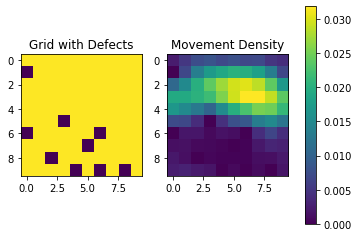

In [116]:
from numpy.ma.core import right_shift
for i in range (grid*grid):
    #The eigen vectors are transposed at each place in the grid
    eig_density[i] = eig_vectors.T[0][i] * eig_vectors.T[0][i]
    #This is the only line of code to change between the two walks
    #Originally the max eigenvector was taken, now any eigenvector in space not assigned to a defect is taken
    density[i]= eig_vectors.T[1][i] * eig_vectors.T[1][i]

#The maximum eigenvector are reshaped to fit within the given grid
density=np.reshape(density,[grid,grid])
#The eigenvectors are also reshaped to fit the grid
eig_density=np.reshape(eig_density,[grid,grid])

#print("Movement Density: ", density)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(Lattice.T)
axs[0].set_title("Grid with Defects")
graph = axs[1].imshow(density.T)
axs[1].set_title("Movement Density")
fig.colorbar(graph, ax=axs)

Same situation as above, I took some code from a person who used simulation to solve and it didn't work fully again. When it gives some values I can tell it's giving reasonable values since there is an equal chance of each move, except when blocked by a defect.

In [140]:
def NN_prob(x0,y0):
    i = int(x0 + (grid*(y0)))
    print("x,y,i:", x0, y0,i)

    ind = np.asarray(np.nonzero(updated_matrix[i]))[0]
    print("Total neighbours:", len(ind))
    prob = [0,0,0,0]
    #print("Non-Zero Indices for :", x0, y0)
    for j in range(len(ind)):
        nbr = ind[j]
        val = matrix[i, nbr]
        x1 = nbr % grid
        y1 = int(nbr / grid)
        dx = x1 - x0
        dy = y1 - y0
        move = ""
        if dx == -1:
            move = "Left"
            prob[2] = val/len(ind)
        elif dx == 1:
            move = "Right"
            prob[3] = val / len(ind)
        elif dy == 1:
            move = "Down"
            prob[1] = val / len(ind)
        elif dy == -1:
            move = "Up"
            prob[0] = val / len(ind)
        elif dx > 1:
            move = "Left"
            prob[2] = val / len(ind)
        elif dx < -1:
            move = "Right"
            prob[3] = val / len(ind)
        elif dy > 1:
            move = "Up"
            prob[0] = val / len(ind)
        elif dy < -1:
            move = "Down"
            prob[1] = val / len(ind)
        else:
            move = "Other"
        print(x1, y1)
        print("dx,dy:", dx, dy, move)
    return prob

In [141]:
for i in range(1, step):
    move_prob = NN_prob(int(x[i-1]%grid),int(y[i-1]%grid))
    print(move_prob)
    move = np.random.choice(direction, p=move_prob) #Randomly choosing the direction of movement.
    print("MOVED:",step)
    if move == "Up":
      if y[i] == rows : #if the simulation position is at the top of the allowed matrix the move will be disregarded
        x[i] = x[i-1]
        y[i] = y[i-1]
      else:
        x[i] = x[i-1]
        y[i] = y[i-1] + 1 #otherwise it will move one position up

    elif move == "Down":
      if y[i] == 0:
        x[i] = x[i-1]
        y[i] = y[i-1]
      else:
        x[i] = x[i-1]
        y[i] = y[i-1] -1


    elif move == "Left":
      if x[i] == 0:
        x[i] = x[i-1]
        y[i] = y[i-1]
      else:    
        x[i] = x[i-1] -1
        y[i] = y[i-1]


    elif move == "Right":
      if x[i] == cols:
        x[i] = x[i-1]
        y[i] = y[i-1]
      else:
        x[i] = x[i-1] +1
        y[i] = y[i-1]

fig, ax = plt.subplots()

x,y,i: 5 5 55
Total neighbours: 4
5 4
dx,dy: 0 -1 Up
4 5
dx,dy: -1 0 Left
6 5
dx,dy: 1 0 Right
5 6
dx,dy: 0 1 Down
[0.25, 0.25, 0.25, 0.25]
MOVED: 1000
x,y,i: 4 5 54
Total neighbours: 4
4 4
dx,dy: 0 -1 Up
3 5
dx,dy: -1 0 Left
5 5
dx,dy: 1 0 Right
4 6
dx,dy: 0 1 Down
[0.25, 0.25, 0.25, 0.25]
MOVED: 1000
x,y,i: 4 4 44
Total neighbours: 4
4 3
dx,dy: 0 -1 Up
3 4
dx,dy: -1 0 Left
5 4
dx,dy: 1 0 Right
4 5
dx,dy: 0 1 Down
[0.0, 0.25, 0.25, 0.25]


ValueError: ignored